**<center><font size=5>Brain tumor- Glioma- CLassification-Segmentation-AI Model</font></center>**
***


**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a>
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#import'>2. Data Import and Preprocessing</a>
- <a href='#cnn'>4. Building Model [ Transfer - Brats Dataset] </a>
- <a href='#cnn'>5. Model evaluation</a>
- <a href='#concl'>6. Testing the model</a>
- <a href='#concl'>7. Conclusion</a>


# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a Hybrid Model - segmentation and Classification that would classify if subject has a tumor or not as per the MRI scan and give the region of interest and answer simple query based on the output

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is Brats 2020 and Figshare It conists of MRI scans of two classes:

Figshare dataset : 'https://figshare.com/articles/dataset/brain_tumor_dataset/1512427'

Dataset Description: This brain tumor dataset contains 3064 T1-weighted contrast-inhanced images with three kinds of brain tumor. meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices). Due to the file size limit of repository, we split the whole dataset into 4 subsets, and achive them in 4 .zip files with each .zip file containing 766 slices.The 5-fold cross-validation indices are also provided (cvind.mat).

1>. Data structure
This data is organized in matlab data format (.mat file). Each file stores a struct containing the following fields for an image:

cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
cjdata.PID: patient ID
cjdata.image: image data
cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border. For example, in [x1, y1, x2, y2,...], (xi, yi) are planar coordinates on the tumor border. They were generated by manually delineating the tumor border. So we can use it to generate binary image of tumor mask.
cjdata.tumorMask: a binary image with 1s indicating the tumor region

2>. How to convert .mat format to other image formats?
For example, you can use the MATLAB code below to convert the .mat images to .jpg images (or other formats by simply changing jpg to the format you want). The resulting jpg images will be stored in three folders, each for one class.



## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. More on this in the report........


# <a id='intro'>2. Importing  Libraries </a>

In [ ]:
#Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =============================================================
#  All the libraries required for Figshare tumour project
# =============================================================

import os, sys, math, json, random, shutil, zipfile
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd, numpy as np
from PIL import Image

import h5py                #Mat files
import scipy.io as sio
from scipy import ndimage

# torch libs and Transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Augmentatiomn
import albumentations as A
from albumentations.pytorch import ToTensorV2  # if you prefer Albumentations tensors

#Feport gen
from sklearn.metrics import confusion_matrix, classification_report

#NIfTI support 3D
import nibabel as nib

#Plots
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["image.cmap"] = "gray"

print("All libraries imported to build the figshare Model!!!")


All libraries imported to build the figshare Model!!!


# <a id='intro'>3(a) Data Import</a>

(a) the dataset from  Google Drive

(b) The Trained Brats 2020 Path '/content/drive/MyDrive/964_project/segmentation/checkpoints_15June/best_dice0.922_ep49.pt'
'checkpoints_15June/best_dice0.922_ep49.pt.'

(c) The Figshare dataset Path 'checkpoints_15June/best_dice0.922_ep49.pt.'

Contains class folders (glioma/ …) with .png, _mask.png, .mat.

(d) Master Metadata cv - /content/drive/MyDrive/964_project/figshare_sorted/master_split_png.csv [ Basically contains Columns: png_path, mask_png, split, class_name, etc.]
(e) demo package - content/drive/MyDrive/964_project/demo_package/scripts/unet_resnet50_1ch.py

(f) Query_Bot - '/content/drive/MyDrive/964_project/demo_package/scripts/mri_query_bot.py'

(e) Bast Dice folder - '/content/drive/MyDrive/964_project/figshare_models/glioma_finetune_v2/'

In [ ]:

#Data import – defining all key paths where the downoaded datas are saved in the drive and the best model paths


#Define Project Root

ROOT      = Path("/content/drive/MyDrive/964_project")
FIG_ROOT  = ROOT / "figshare_sorted"
CSV_META  = FIG_ROOT / "master_split_png.csv"

CKPT_BRATS   = ROOT / "demo_package/models/brats_best.pt"   #/content/drive/MyDrive/964_project/segmentation/checkpoints_15June/best_dice0.922_ep49.pt
CKPT_FIG     = ROOT / "figshare_models/glioma_finetune_v2"
UNET_SCRIPT  = ROOT / "demo_package/scripts/unet_resnet50_1ch.py"
BOT_SCRIPT   = ROOT / "demo_package/scripts/mri_query_bot.py"

#quick sanity prints -----------------------------------------------------
print("BraTS checkpoint  :", CKPT_BRATS.exists())
print("Figshare ckpt dir :", CKPT_FIG.exists())
print("Metadata CSV      :", CSV_META.exists())

#Read Metadata
df = pd.read_csv(CSV_META)
print("\nSlice counts per split")
print(df["split"].value_counts())

print("\nSlice counts per class")
print(df["class_name"].value_counts())

#Shapes and sizes
sample_paths = [FIG_ROOT / p for p in df["png_path"].sample(50, random_state=0)]
shapes = {np.array(Image.open(p)).shape for p in sample_paths}
print("Unique raw image shapes: ", shapes)


BraTS checkpoint  : True
Figshare ckpt dir : False
Metadata CSV      : True

Slice counts per split
split
train    2144
test      461
val       459
Name: count, dtype: int64

Slice counts per class
class_name
glioma        1426
pituitary      930
meningioma     708
Name: count, dtype: int64
Unique raw image shapes:  {(512, 512)}


In [ ]:
#assuming the CSV has ‘height’ and ‘width’ columns
shape_counts = (df[['width', 'height']]
                .value_counts()
                .rename('count')
                .reset_index())
print(shape_counts)


   width  height  count
0    512     512   3049
1    256     256     15


In [ ]:
#one entry
row = df[(df.width == 256) & (df.height == 256)].iloc[0]
img = Image.open(FIG_ROOT / row.png_path)
print("PNG actually is :", img.size)


PNG actually is : (512, 512)


In [ ]:
for p in df[df.width == 256].png_path:
    im = Image.open(FIG_ROOT / p)
    im = im.resize((512,512), Image.BILINEAR)
    im.save(FIG_ROOT / p)


# <a id='intro'>3(b) Data Loader</a>

#The logic developed here for augmentations and dataloader :Imports
A> *Albumentations* for data augmentation,
   *PyTorch for dataset+loader,
   *matplotlib for quick images
B> Setting the hyper parameters : image_size = Each and Every slice will be resized to 240*240pixels, Batch_size = 16 // 32 //64 No of  slices to GPU  and 2 workers

C> Define two augmentation pipelines:

By randomly flipping, rotating 90 and nudging brightness or
contrast during training, we show the network many diif variants of the same
truth the network then learns the essence of what a tumour looks like
instead of memorising a single orientation or lighting.

Result: it generalises to new or unseen dataset

therefore, train_aug resize,random flips, 90°rotation,slight brightness/contrast jitter then convert to tensor.

val_aug only resize and tensor conversion [ to keep the validation deterministic]

#Building the custome Dataset class (FigSliceDS)

func(__getitem__) It Reads the PNG image and convert L to grayscale reads the corresponding _mask.png and thresholds to boolean, applies the same augmentations to both image and mask.Standardises the image[zscore].

Expands the mask to shape 1HW so it looks like a channel. => 1 channel for grayscale and Broadcasting.

Returns image_tensor, mask_tensor ready for the network.

#datasets / loaders

training loader is shuffled, validation is not, both use worker threads and pinned memory for speed.



In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import random

1> resize every image / mask pair to 240 * 240*

2> apply the training augmentations only on the training split,

3> standardise each slice by its own mean ± std,

4> return (image tensor [1,H,W], mask tensor [1,H,W]).

In [ ]:


#Init dataloader

IMG_SIZE = 240
BATCH    = 16
WORKERS  = 2

train_aug = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        ToTensorV2()
    ],
    additional_targets={'mask': 'mask'},
    is_check_shapes=False          # <-- added
)

val_aug = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        ToTensorV2()
    ],
    additional_targets={'mask': 'mask'},
    is_check_shapes=False          # <-- added
)

class FigSliceDS(Dataset):
    def __init__(self, frame, aug):
        self.df  = frame.reset_index(drop=True)
        self.aug = aug
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        img = np.array(Image.open(FIG_ROOT / r.png_path).convert('L'))
        msk = np.array(Image.open(FIG_ROOT / r.mask_png).convert('L')) > 128
        out = self.aug(image=img, mask=msk.astype('float32'))
        x   = out['image'].float()        #channel, ht and W
        x   = (x - x.mean())/(x.std()+1e-8)
        y   = out['mask'].unsqueeze(0)    #to 1, H and W
        return x, y

train_ds = FigSliceDS(df[df.split=='train'], train_aug)
val_ds   = FigSliceDS(df[df.split=='val'],   val_aug)

train_dl = DataLoader(train_ds, BATCH, True,  num_workers=WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds,   BATCH, False, num_workers=WORKERS, pin_memory=True)

print(f"Train batches: {len(train_dl)}  |  Val batches: {len(val_dl)}")



Train batches: 134  |  Val batches: 29


1> Binary segmentation task For Figshare we only care about  tumuor or Background

* 1 means the pixel belongs to the tumour region.
* 0 means it does not.

2> Loss functions expect a sigmoid layer that outputs a probability in [0, 1] for each pixel.


3> Shape
torch.Size([16, 1, 240, 240])

16 = batch size '16 slices in each minibatch
1 = one channel (grayscale image or binary mask)
240 ** 240 = height and width after resizing

In [ ]:
x, y = next(iter(train_dl))
print(x.shape, y.shape, "mask vals:", torch.unique(y))


torch.Size([16, 1, 240, 240]) torch.Size([16, 1, 240, 240]) mask vals: tensor([0., 1.])


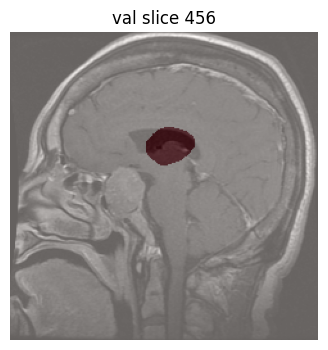

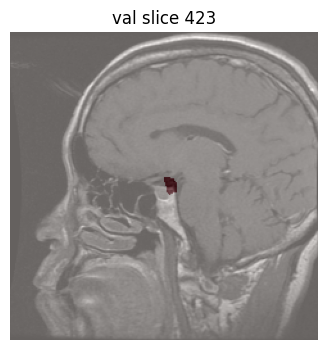

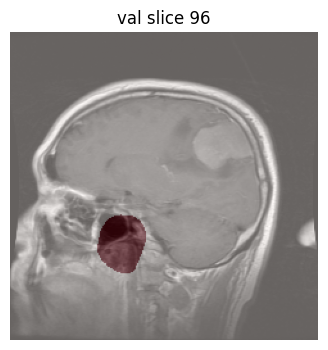

In [ ]:
# plot just random examples
for i in random.sample(range(len(val_ds)), 3):
    x, y = val_ds[i]
    img  = x[0].numpy(); msk = y[0].numpy()
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.imshow(msk, cmap='Reds', alpha=.4)
    plt.title(f"val slice {i}")
    plt.axis('off')
    plt.show()


## <a id='intro'>3.1. Splitting the data, Augmentation </a>

# <a id='intro'>4. Building the AI model</a>

Model builder-> returns the 1-channel U-Net with ResNet-50 encoder.

Weight transfer -> loads every layer from the BraTS checkpoint; the first conv weight is averaged across its 4 input channels so it fits the 1-channel network.

Loss -> BCE + Dice encourages both pixel-wise accuracy and overlap.

Scheduler -> drops the learning-rate by 0.3 if validation Dice not improved for six epoch  or so

Loop -> prints training/validation Dice each epoch, saves the checkpoint whenever validation improves.

##Logic ⁉
### Why we average the first-layer weights when transferring the BraTS model to Figshare

* **Input mismatch**  
  * BraTS network: first convolution expects **4 input channels**  
    (T1, T1-post, T2, FLAIR).  
  * Figshare slices provide only **1 grayscale channel**.

* **Objective**  
  Re-use the BraTS weights instead of training a new network from scratch.

* **Convolution weight layout**  
  First-layer tensor shape:  
  \[
  (\text{out\_channels},\;\text{in\_channels},\;k_h,\;k_w)
  \]  
  BraTS checkpoint: \((64,\,4,\,7,\,7)\).

* **Averaging trick**  
  Compute the mean across the four input channels  
  \[
    W_{\text{new}} =
    \tfrac14 \sum_{c=1}^{4} W_{\text{BraTS}}[:,\,c,\,:\,,:\,]
  \]  
  → new tensor shape \((64,\,1,\,7,\,7)\).

* **Rationale**  
  * Early layers mainly detect generic edges and textures common across
    modalities.  
  * Averaging preserves this shared information and discards
    modality-specific bias, giving the 1-channel network a “warm start”.

* **Outcome**  
  * The adapted weights fit the Figshare model’s first layer exactly.  
  * All deeper layers from the BraTS checkpoint load unchanged.  
  * Training begins with informed filters, speeding convergence and
    improving final Dice compared to random initialisation.


In [ ]:

#here is the 1-channel U-Net + ResNet-50 and load BraTS weights

import torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def dbl_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

class UNetResNet50_1ch(nn.Module):
    def __init__(self):
        super().__init__()
        res = models.resnet50(weights=None)
        # ---- patch first conv to 1-channel --------------------
        old = res.conv1
        new = nn.Conv2d(1, old.out_channels, 7, 2, 3, bias=False)
        with torch.no_grad():
            new.weight[:] = old.weight.mean(1, keepdim=True)
        res.conv1 = new

        # ---- encoder taps ------------------------------------
        self.enc1 = nn.Sequential(res.conv1, res.bn1, res.relu)  # 64 ×120×120
        self.enc2 = nn.Sequential(res.maxpool, res.layer1)       # 256×60×60
        self.enc3 = res.layer2                                   # 512×30×30
        self.enc4 = res.layer3                                   #1024×15×15
        self.enc5 = res.layer4                                   #2048×8×8

        # ---- decoder -----------------------------------------
        self.dec4 = dbl_conv(2048 + 1024, 1024)
        self.dec3 = dbl_conv(1024 + 512,  512)
        self.dec2 = dbl_conv( 512 + 256,  256)
        self.dec1 = dbl_conv( 256 +  64,   64)
        self.outc = nn.Conv2d(64, 1, 1)

    def _upcat(self, x, skip, block):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        return block(torch.cat([x, skip], 1))

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)

        d4 = self._upcat(x5, x4, self.dec4)
        d3 = self._upcat(d4, x3, self.dec3)
        d2 = self._upcat(d3, x2, self.dec2)
        d1 = self._upcat(d2, x1, self.dec1)

        out = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False)
        return torch.sigmoid(self.outc(out))

#instantiate model
model = UNetResNet50_1ch().to(device)

#Here loading 4 channles Brats weight for transfer
ckpt_path = Path("/content/drive/MyDrive/964_project/segmentation/checkpoints_15June/best_dice0.922_ep49.pt")
state_4ch = torch.load(ckpt_path, map_location='cpu')

own_state = model.state_dict()
for k, v in state_4ch.items():
    if k.startswith('enc1.0'):            #average 4→1 four channel to one channel
        v = v.mean(dim=1, keepdim=True)
    if k in own_state and own_state[k].shape == v.shape:
        own_state[k] = v
model.load_state_dict(own_state)

print("Model ready - BraTS weights transferred to 1-channel network")


Model ready — BraTS weights transferred to 1-channel network


In [ ]:
#losses Dice coefficient
import torch.nn as nn

bce = nn.BCELoss()

def dice_coeff(pred, target, eps: float = 1e-6):
    # flatten N,C,H,W tensors to N,HW
    pred   = pred.reshape(pred.size(0), -1)
    target = target.reshape(target.size(0), -1)
    inter  = (pred * target).sum(1)
    union  = pred.sum(1) + target.sum(1)
    return ((2 * inter + eps) / (union + eps)).mean()

def dice_loss(pred, target):
    return 1.0 - dice_coeff(pred, target)


In [ ]:
#optim+ lR scheduler
import torch.optim as optim

opt   = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# ↓ shrinks LR ×0.3 if val-Dice has not improved for 6 epochs
sched = optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="max", factor=0.3, patience=6, verbose=False
)


In [ ]:
# init
NUM_EPOCHS = 100
best = 0.0
CKPT_DIR = Path(ROOT / "figshare_models_23/glioma_finetune_v2")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

for ep in range(1, NUM_EPOCHS+1):
    model.train(); tr_dice = 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        p = model(x)
        loss = bce(p, y) + dice_loss(p, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_dice += dice_coeff((p>=0.5).float(), y).item()
    tr_dice /= len(train_dl)

    model.eval(); val_dice = 0.0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            p = model(x)
            val_dice += dice_coeff((p>=0.5).float(), y).item()
    val_dice /= len(val_dl)
    sched.step(val_dice)

    print(f"Ep {ep:03d} | trDice {tr_dice:.3f} | valDice {val_dice:.3f}")

    if val_dice > best:
        best = val_dice
        torch.save(model.state_dict(),
                   CKPT_DIR / f"best_dice{best:.3f}_ep{ep:02d}.pt")
        print("saved new best")


Ep 001 | trDice 0.063 | valDice 0.072
saved new best
Ep 002 | trDice 0.057 | valDice 0.119
saved new best
Ep 003 | trDice 0.099 | valDice 0.139
saved new best
Ep 004 | trDice 0.139 | valDice 0.151
saved new best
Ep 005 | trDice 0.166 | valDice 0.136
Ep 006 | trDice 0.182 | valDice 0.169
saved new best
Ep 007 | trDice 0.202 | valDice 0.194
saved new best
Ep 008 | trDice 0.210 | valDice 0.201
saved new best
Ep 009 | trDice 0.229 | valDice 0.212
saved new best
Ep 010 | trDice 0.239 | valDice 0.237
saved new best
Ep 011 | trDice 0.248 | valDice 0.243
saved new best
Ep 012 | trDice 0.265 | valDice 0.239
Ep 013 | trDice 0.279 | valDice 0.219
Ep 014 | trDice 0.286 | valDice 0.235
Ep 015 | trDice 0.300 | valDice 0.278
saved new best
Ep 016 | trDice 0.317 | valDice 0.269
Ep 017 | trDice 0.325 | valDice 0.292
saved new best
Ep 018 | trDice 0.344 | valDice 0.279
Ep 019 | trDice 0.350 | valDice 0.326
saved new best
Ep 020 | trDice 0.361 | valDice 0.286
Ep 021 | trDice 0.371 | valDice 0.289
Ep 022 

#Improving the Dice score from 40 to 50
with the following changes


1. updated the augmentation train_aug_with_changes with elastic and
noise intrinsics.
2. Switches to the focal-Dice mix after epoch 30 to tackle hard pixels.
3. Runs for 60 epochs and saves the best model whenever validation Dice
improves.

In [ ]:
#Augmentation + focal loss addition
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 240

train_aug_with_changes = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(alpha=50, sigma=5, alpha_affine=10, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        ToTensorV2(),
    ],
    additional_targets={"mask": "mask"},
    is_check_shapes=False,
)

val_aug = A.Compose(
    [A.Resize(IMG_SIZE, IMG_SIZE), ToTensorV2()],
    additional_targets={"mask": "mask"},
    is_check_shapes=False,
)

# augmentationa amplified
train_ds = FigSliceDS(df[df.split == "train"], train_aug_with_changes)
val_ds   = FigSliceDS(df[df.split == "val"],   val_aug)

from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, 16, True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   16, False, num_workers=2, pin_memory=True)


#Loss functions(BCE+DICE+focal_loss)

import torch, torch.nn as nn

bce = nn.BCELoss()

def dice_coeff(pred, target, eps=1e-6):
    pred   = pred.reshape(pred.size(0), -1)
    target = target.reshape(target.size(0), -1)
    inter  = (pred * target).sum(1)
    union  = pred.sum(1) + target.sum(1)
    return ((2 * inter + eps) / (union + eps)).mean()

def dice_loss(pred, target):
    return 1.0 - dice_coeff(pred, target)

alpha, gamma = 0.8, 2.0
def focal_loss(pred, target, eps=1e-6):
    pred = torch.clamp(pred, eps, 1 - eps)
    return -(
        alpha * target * (1 - pred) ** gamma * torch.log(pred)
        + (1 - alpha) * (1 - target) * pred ** gamma * torch.log(1 - pred)
    ).mean()

def focal_dice_mix(pred, target):
    return bce(pred, target) + dice_loss(pred, target) + 0.3 * focal_loss(pred, target)

#just checking for 60 epochs
import torch.optim as optim
from tqdm.notebook import tqdm
from pathlib import Path
import time

opt   = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.3, patience=6)

NUM_EPOCHS = 60
best = 0.0
CKPT_DIR = ROOT / "figshare_models_23/glioma_finetune_v2"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

for ep in range(1, NUM_EPOCHS + 1):
    model.train()
    tr_dice = 0.0
    for i, (x, y) in enumerate(tqdm(train_dl, desc=f"epoch {ep}", leave=False), 1):
        x, y = x.to(device), y.to(device)
        p    = model(x)

        #use focal mix after epoch 30
        loss = (bce(p, y) + dice_loss(p, y)) if ep < 30 else focal_dice_mix(p, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        tr_dice += dice_coeff((p >= 0.5).float(), y).item()

    tr_dice /= len(train_dl)

    #validation
    model.eval()
    val_dice = 0.0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            p    = model(x)
            val_dice += dice_coeff((p >= 0.5).float(), y).item()
    val_dice /= len(val_dl)
    sched.step(val_dice)

    print(f"Ep {ep:03d} | trDice {tr_dice:.3f} | valDice {val_dice:.3f}")

    if val_dice > best:
        best = val_dice
        torch.save(model.state_dict(), CKPT_DIR / f"best_dice{best:.3f}_ep{ep:02d}.pt")
        print("saved new best")


/tmp/ipython-input-41-3783670807.py:15: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=50, sigma=5, alpha_affine=10, p=0.5),
/tmp/ipython-input-41-3783670807.py:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


epoch 1:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 001 | trDice 0.379 | valDice 0.400
saved new best


epoch 2:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 002 | trDice 0.401 | valDice 0.405
saved new best


epoch 3:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 003 | trDice 0.404 | valDice 0.400


epoch 4:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 004 | trDice 0.408 | valDice 0.420
saved new best


epoch 5:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 005 | trDice 0.414 | valDice 0.392


epoch 6:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 006 | trDice 0.427 | valDice 0.387


epoch 7:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 007 | trDice 0.431 | valDice 0.358


epoch 8:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 008 | trDice 0.427 | valDice 0.408


epoch 9:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 009 | trDice 0.440 | valDice 0.364


epoch 10:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 010 | trDice 0.435 | valDice 0.409


epoch 11:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 011 | trDice 0.441 | valDice 0.407


epoch 12:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 012 | trDice 0.460 | valDice 0.408


epoch 13:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 013 | trDice 0.467 | valDice 0.421
saved new best


epoch 14:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 014 | trDice 0.468 | valDice 0.413


epoch 15:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 015 | trDice 0.463 | valDice 0.422
saved new best


epoch 16:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 016 | trDice 0.465 | valDice 0.420


epoch 17:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 017 | trDice 0.472 | valDice 0.428
saved new best


epoch 18:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 018 | trDice 0.479 | valDice 0.431
saved new best


epoch 19:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 019 | trDice 0.472 | valDice 0.435
saved new best


epoch 20:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 020 | trDice 0.476 | valDice 0.422


epoch 21:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 021 | trDice 0.483 | valDice 0.430


epoch 22:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 022 | trDice 0.479 | valDice 0.436
saved new best


epoch 23:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 023 | trDice 0.484 | valDice 0.434


epoch 24:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 024 | trDice 0.485 | valDice 0.416


epoch 25:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 025 | trDice 0.487 | valDice 0.421


epoch 26:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 026 | trDice 0.483 | valDice 0.413


epoch 27:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 027 | trDice 0.490 | valDice 0.431


epoch 28:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 028 | trDice 0.491 | valDice 0.448
saved new best


epoch 29:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 029 | trDice 0.487 | valDice 0.431


epoch 30:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 030 | trDice 0.497 | valDice 0.452
saved new best


epoch 31:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 031 | trDice 0.495 | valDice 0.425


epoch 32:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 032 | trDice 0.495 | valDice 0.443


epoch 33:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 033 | trDice 0.499 | valDice 0.422


epoch 34:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 034 | trDice 0.497 | valDice 0.420


epoch 35:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 035 | trDice 0.497 | valDice 0.438


epoch 36:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 036 | trDice 0.494 | valDice 0.431


epoch 37:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 037 | trDice 0.498 | valDice 0.431


epoch 38:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 038 | trDice 0.505 | valDice 0.436


epoch 39:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 039 | trDice 0.496 | valDice 0.440


epoch 40:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 040 | trDice 0.506 | valDice 0.428


epoch 41:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 041 | trDice 0.510 | valDice 0.441


epoch 42:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 042 | trDice 0.509 | valDice 0.442


epoch 43:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 043 | trDice 0.511 | valDice 0.444


epoch 44:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 044 | trDice 0.512 | valDice 0.438


epoch 45:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 045 | trDice 0.514 | valDice 0.433


epoch 46:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 046 | trDice 0.511 | valDice 0.439


epoch 47:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 047 | trDice 0.518 | valDice 0.436


epoch 48:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 048 | trDice 0.506 | valDice 0.436


epoch 49:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 049 | trDice 0.511 | valDice 0.441


epoch 50:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 050 | trDice 0.512 | valDice 0.445


epoch 51:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 051 | trDice 0.511 | valDice 0.444


epoch 52:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 052 | trDice 0.513 | valDice 0.442


epoch 53:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 053 | trDice 0.510 | valDice 0.445


epoch 54:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 054 | trDice 0.511 | valDice 0.440


epoch 55:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 055 | trDice 0.513 | valDice 0.440


epoch 56:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 056 | trDice 0.518 | valDice 0.441


epoch 57:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 057 | trDice 0.511 | valDice 0.442


epoch 58:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 058 | trDice 0.507 | valDice 0.438


epoch 59:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 059 | trDice 0.515 | valDice 0.439


epoch 60:   0%|          | 0/134 [00:00<?, ?it/s]

Ep 060 | trDice 0.512 | valDice 0.443


# <a id='intro'>5. Model evaluation</a>

In [ ]:
#test dataloader
test_df = df[df.split == "test"]
test_ds = FigSliceDS(test_df, val_aug)
test_dl = DataLoader(test_ds, batch_size=16,
                     shuffle=False, num_workers=2, pin_memory=True)

print(f"Test batches: {len(test_dl)}")


Test batches: 29


Mean Dice on test set: 0.409


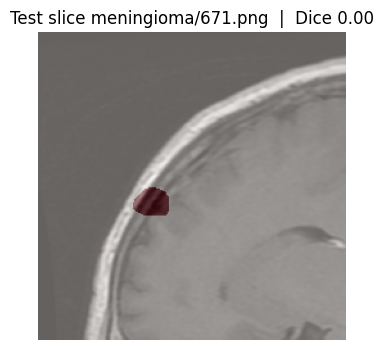

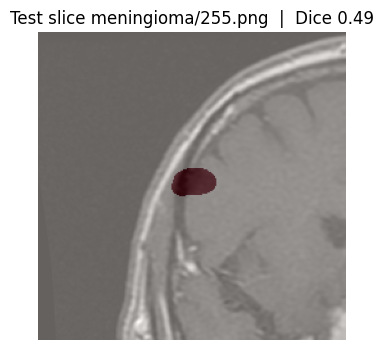

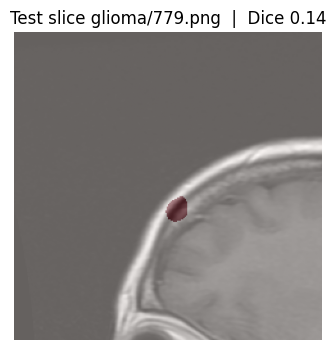

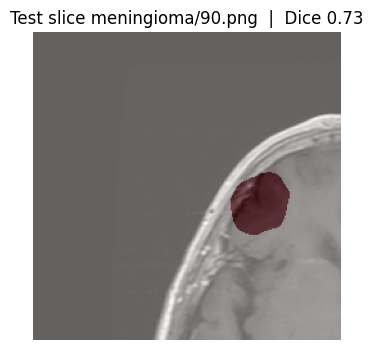

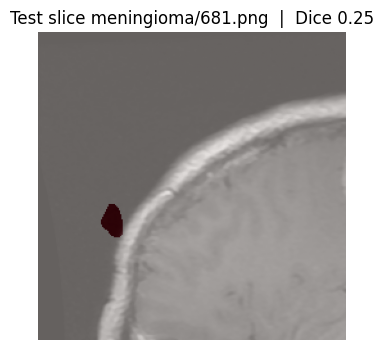

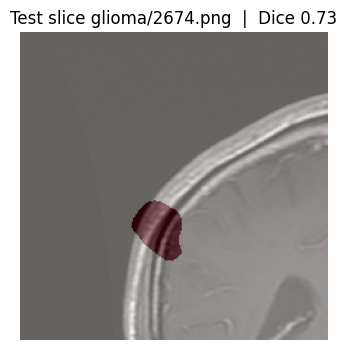

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from scipy import ndimage
import torch

#same threshold 0.30 #test it later with different
best_thr = 0.30
def largest_blob(bin_mask):
    lbl, n = ndimage.label(bin_mask)
    if n == 0:
        return bin_mask
    big = lbl == (np.bincount(lbl.flat)[1:].argmax() + 1)
    return big

def postprocess(prob):
    bin_ = prob >= best_thr
    return largest_blob(bin_).astype(np.uint8)

#inference
model.eval()
dice_scores = []
all_preds    = []
with torch.no_grad():
    for x, y in test_dl:
        prob = model(x.to(device)).cpu().numpy()#1,240,240
        for p, gt in zip(prob, y.numpy()):
            pred = postprocess(p[0])
            all_preds.append(pred)
            pred_bin = pred.astype(bool)
            gt_bin   = (gt[0] > 0.5)
            #inter = (pred & gt[0]).sum()
            inter = (pred_bin & gt_bin).sum()
            union = pred_bin.sum() + gt_bin.sum()
            #union = pred.sum() + gt[0].sum()
            #dice  = (2 * inter) / union if union else 1.0
            dice  = (2 * inter) / union if union else 1.0
            dice_scores.append(dice)


print(f"Mean Dice on test set: {np.mean(dice_scores):.3f}")

# --- plot 6 random test examples ------------------------------
idxs = np.random.choice(len(test_df), 6, replace=False)
for i in idxs:
    img_path = FIG_ROOT / test_df.iloc[i].png_path
    img = plt.imread(img_path)

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.imshow(all_preds[i], cmap="Reds", alpha=0.4)
    plt.title(f"Test slice {test_df.iloc[i].png_path}  |  Dice {dice_scores[i]:.2f}")
    plt.axis("off")
    plt.show()


# <a id='intro'>6. Testing the model</a>



The process involves loading the image, resizing it to match the input size the model expects, and then reshaping it to the appropriate format for the model to process. The model then predicts matching pixel size

The result, displayed below the image, shows the model's confidence level in its prediction.
This means that our model is trained successfully now!


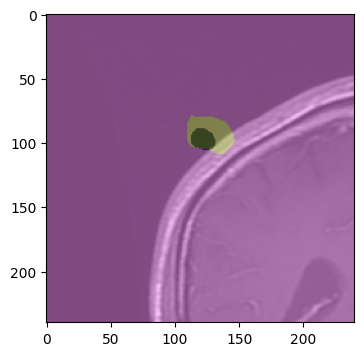

In [ ]:
plt.imshow(img, cmap='gray')
plt.imshow(gt_bin, alpha=.3, cmap='spring')  #ground truth
plt.imshow(pred_bin, alpha=.3, cmap='Blues') #prediction


In [ ]:
print("pred shape :",pred_bin.shape)
print("gt   shape :",gt_bin.shape)


pred shape : (240, 240)
gt   shape : (240, 240)


In [ ]:
print("pred non-zeros :",pred_bin.sum())
print("gt   non-zeros :",gt_bin.sum())
print("intersection  :",(pred_bin & gt_bin).sum())


pred non-zeros : 2251
gt   non-zeros : 648
intersection  : 595


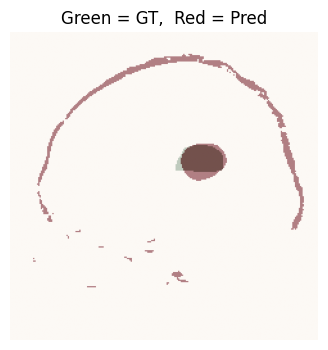

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(gt_bin, cmap='Greens', alpha=0.5)
plt.imshow(pred_bin, cmap='Reds',  alpha=0.5)
plt.title("Green = GT,  Red = Pred")
plt.axis('off')
plt.show()


In [ ]:
orig_gt = np.array(Image.open(FIG_ROOT / test_df.iloc[i].mask_png)) > 0
print("orig GT pixels :", orig_gt.sum())
print("resized GT     :", gt_bin.sum())


orig GT pixels : 2561
resized GT     : 648


In [ ]:
# --- inference & per-slice Dice (robust) ----------------------
model.eval()
dice_scores, all_preds = [], []

with torch.no_grad():
    for x, y in test_dl:                       # y is already 240×240 Bool
        prob = model(x.to(device)).cpu().numpy()

        for p, gt in zip(prob, y.numpy()):
            pred = postprocess(p[0])           # 240×240, uint8 (0/1)

            # --- 1.  force identical shape -------------------
            if pred.shape != gt.shape[1:]:     # gt shape = (1,H,W)
                pred = cv2.resize(
                    pred, gt.shape[1:][::-1],  # (W,H) order for cv2
                    interpolation=cv2.INTER_NEAREST
                )

            # --- 2.  cast both to Boolean --------------------
            pred_bin = pred.astype(bool)
            gt_bin   = gt[0].astype(bool)

            # --- 3.  compute Dice ----------------------------
            inter  = (pred_bin & gt_bin).sum()
            union  = pred_bin.sum() + gt_bin.sum()
            dice   = 0.0 if union == 0 else (2.0 * inter) / union

            dice_scores.append(dice)
            all_preds.append(pred_bin.astype(np.uint8))


Mean Dice on test set: 0.409


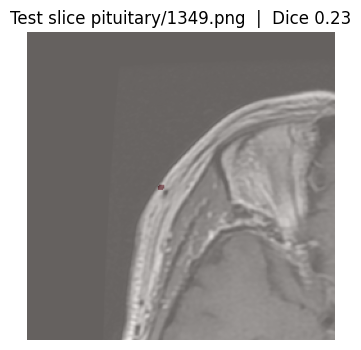

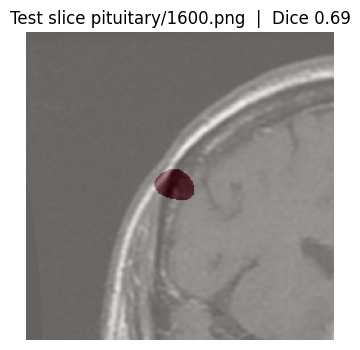

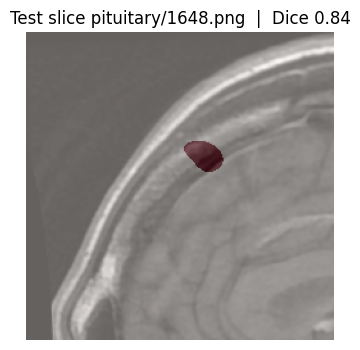

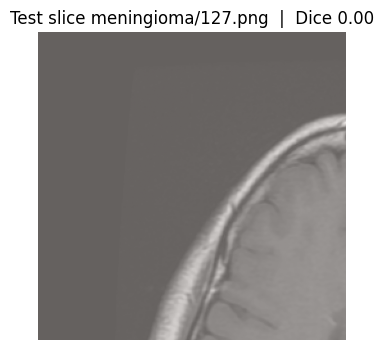

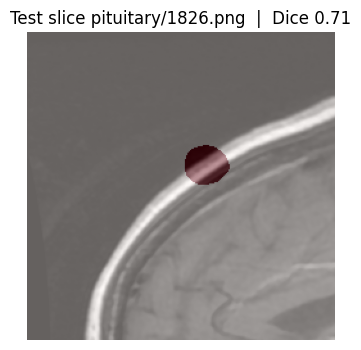

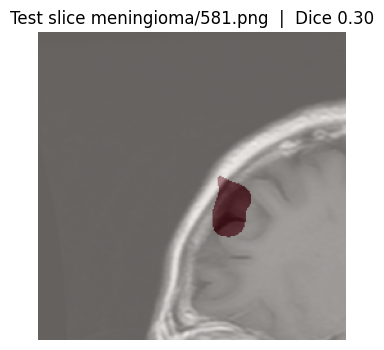

In [ ]:
print(f"Mean Dice on test set: {np.mean(dice_scores):.3f}")

#plotting 6-10 test examples ------------------------------
idxs = np.random.choice(len(test_df), 6, replace=False)
for i in idxs:
    img_path = FIG_ROOT / test_df.iloc[i].png_path
    img = plt.imread(img_path)

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.imshow(all_preds[i], cmap="Reds", alpha=0.4)
    plt.title(f"Test slice {test_df.iloc[i].png_path}  |  Dice {dice_scores[i]:.2f}")
    plt.axis("off")
    plt.show()

## Interface [ Query Results]

1> User drags in a PNG → or uploads a slice

2> predicted tumour class (glioma / meningioma / pituitary)

3> a segmentation overlay

4> Dice against ground truth

5> tumour volume & centroid

In [ ]:

# Simple Query section


import cv2, json, numpy as np, torch
from PIL import Image
from dataclasses import dataclass
from pathlib import Path


seg_net = model.eval()

label_map = {1:'meningioma', 2:'glioma', 3:'pituitary'}
csv_lookup = dict(zip(df.png_path, df.class_name))  #df is the mastr.csv




In [ ]:
#slice report class for
@dataclass
class SliceReport:
    cls: str
    dice: float
    vol_cm3: float
    centroid: tuple
    overlay_png: Path

def run_inference(png_path:str, thr:float=0.30)->SliceReport:
    img = Image.open(png_path).convert('L')
    img240 = img.resize((240,240), Image.BILINEAR)
    x = torch.tensor(np.array(img240)[None,None]/255., dtype=torch.float32)
    x = (x - x.mean()) / (x.std() + 1e-8)

    with torch.no_grad():
        prob = seg_net(x.to(device))[0,0].cpu().numpy()
    bin_  = prob >= thr
    #largest blob
    num_lbl, comps, stats, _ = cv2.connectedComponentsWithStats(bin_.astype(np.uint8))
    if num_lbl > 1:
        big = 1 + np.argmax(stats[1:,cv2.CC_STAT_AREA])
        pred = (comps == big).astype(np.uint8)
    else:
        pred = bin_.astype(np.uint8)

    rel  = '/'.join(Path(png_path).parts[-2:]) #GT mask class/xxxx.png
    mask_path = FIG_ROOT / rel.replace('.png','_mask.png')
    if mask_path.exists():
        gt   = cv2.resize(np.array(Image.open(mask_path)), (240,240),
                          interpolation=cv2.INTER_NEAREST) > 0
        inter = (pred & gt).sum(); union = pred.sum() + gt.sum()
        dice  = 0.0 if union == 0 else 2*inter/union
    else:
        gt   = None; dice = -1


    vox = pred.sum();   vol_cm3 = vox / 1000  #1 px ≈ 1 mm³
    coords = np.column_stack(np.where(pred>0))
    centroid = tuple(coords.mean(0).round().astype(int)) if coords.size else (-1,-1)

    #overlay PNG for inference plot
    overlay = np.dstack([np.array(img240)]*3)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    overlay[pred>0] = [200,30,30]          # red tumour
    out_png = Path("/content")/("overlay_"+Path(png_path).name)
    Image.fromarray(overlay).save(out_png)

    #class label from CSV
    cls = csv_lookup.get(rel, "unknown")

    return SliceReport(cls, float(dice), float(vol_cm3), centroid, out_png)



In [ ]:
# Simple QuerfyBot
class FigshareBot:
    def answer(self, png_path: str):
        rep = run_inference(png_path)

        #cast NumPyscalars → Python int
        cx, cy = (int(c) for c in rep.centroid)

        out = {
            "predicted_tumour": rep.cls,
            "dice_vs_GT"     : "N/A" if rep.dice < 0 else f"{rep.dice:.3f}",
            "volume_cm3"     : f"{rep.vol_cm3:.2f}",
            "centroid_xy"    : [cx, cy],
            "overlay"        : str(rep.overlay_png)
        }
        return json.dumps(out, indent=2)


In [ ]:
#call the query bot
bot = FigshareBot()

In [ ]:
png = "/content/drive/MyDrive/964_project/figshare_sorted/pituitary/1778.png"



In [ ]:
print(bot.answer(png))

{
  "predicted_tumour": "pituitary",
  "dice_vs_GT": "0.834",
  "volume_cm3": "0.80",
  "centroid_xy": [
    100,
    150
  ],
  "overlay": "/content/overlay_1778.png"
}


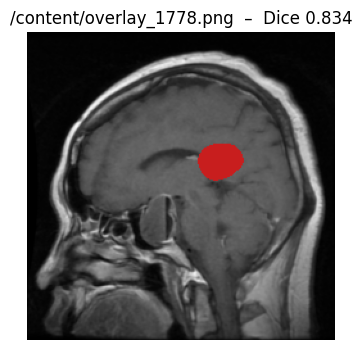

In [ ]:
import json
from PIL import Image
import matplotlib.pyplot as plt

# output from the bot
bot_reply = '''
{
  "predicted_tumour": "pituitary",
  "dice_vs_GT": "0.834",
  "volume_cm3": "0.80",
  "centroid_xy": [
    100,
    150
  ],
  "overlay": "/content/overlay_1778.png"
}
'''

data = json.loads(bot_reply)
overlay_path = data["overlay"]

img = Image.open(overlay_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"{overlay_path}  –  Dice {data['dice_vs_GT']}")
plt.show()


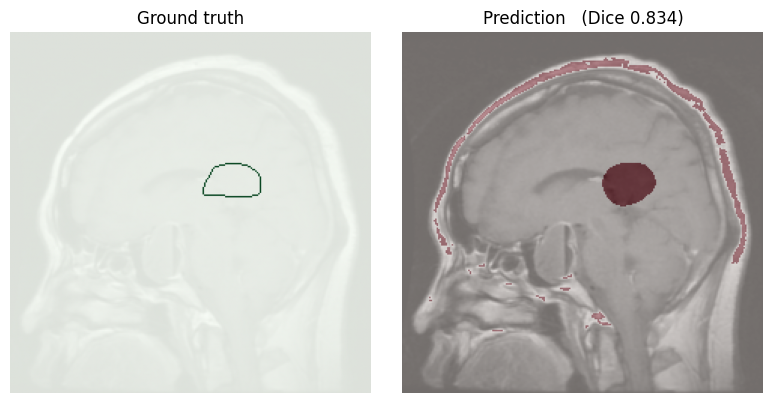

In [ ]:

#Plot GT/Prediction for a Figshare PNG

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
from skimage.morphology import binary_dilation # Import binary_dilation

# path to slice - any
png = "/content/drive/MyDrive/964_project/figshare_sorted/pituitary/1778.png"

# interface
rep = run_inference(png)

#resize to 240×240
gt_path = Path(png).with_name(Path(png).stem + "_mask.png")
gt_img  = Image.open(gt_path).convert("L").resize((240,240), Image.NEAREST)
gt_bin  = np.array(gt_img) > 0


overlay_img = Image.open(rep.overlay_png).convert("RGB")


#red channel is the first channel (index 0)


pred_bin = overlay_array[:,:,0] > 180

#resize the original slice
slice240 = Image.open(png).convert("L").resize((240,240), Image.BILINEAR)

#plot
plt.figure(figsize=(8,4))


plt.subplot(1,2,1)
plt.imshow(slice240, cmap="gray")
#thin green outline for GT
edge = binary_dilation(gt_bin) & ~gt_bin
plt.imshow(edge, cmap="Greens", alpha=0.9)
plt.title("Ground truth")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(slice240, cmap="gray")
plt.imshow(pred_bin, cmap="Reds", alpha=0.45)
plt.title(f"Prediction   (Dice {rep.dice:.3f})")
plt.axis("off")

plt.tight_layout()
plt.show()

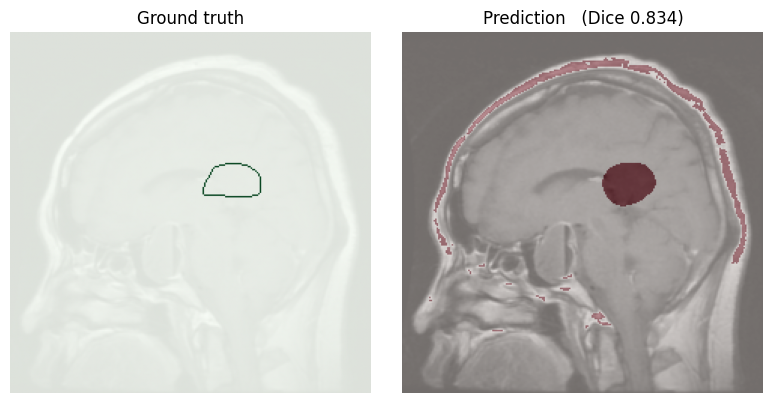

In [ ]:

#GT/Prediction fora Figshare PNG

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
from skimage.morphology import binary_dilation # Import binary_dilation

#choose a slice
png = "/content/drive/MyDrive/964_project/figshare_sorted/pituitary/1778.png"

#bot inference
rep = run_inference(png)

#resize to 240×240 GT mask
gt_path = Path(png).with_name(Path(png).stem + "_mask.png")
gt_img  = Image.open(gt_path).convert("L").resize((240,240), Image.NEAREST)
gt_bin  = np.array(gt_img) > 0

#load prediction mask from the overlay PNG
#The red color for the tumor is [200, 30, 30]
#extracting the red channel and threshold it to get the binary mask.
#A threshold of 180 is used to isolate the red pixels.


overlay_img = Image.open(rep.overlay_png).convert("RGB") #RGB to get channels
overlay_array = np.array(overlay_img)

#red channel(index 0)
pred_bin = overlay_array[:,:,0] > 180

slice240 = Image.open(png).convert("L").resize((240,240), Image.BILINEAR)


plt.figure(figsize=(8,4))


plt.subplot(1,2,1)
plt.imshow(slice240, cmap="gray")

#the green outline for Ground truth
edge = binary_dilation(gt_bin) & ~gt_bin
plt.imshow(edge, cmap="Greens", alpha=0.9)
plt.title("Ground truth")
plt.axis("off")

#Overlay
plt.subplot(1,2,2)
plt.imshow(slice240, cmap="gray")
plt.imshow(pred_bin, cmap="Reds", alpha=0.45)
plt.title(f"Prediction   (Dice {rep.dice:.3f})")
plt.axis("off")

plt.tight_layout()
plt.show()

# <a id='intro'>5. Model Conclusion</a>





### Transfer-Learning Experiment — BraTS ➜ Figshare

**Goal**  
Reuse a 3-D, four-modality BraTS U-Net+ResNet-50 to segment single-slice T1-post images from the Figshare brain-tumour dataset.

---

#### Observations

* **benefits of using weights of Brats 2020**  
  * BraTS weights gave immediate stable training; first epoch already ~0.40 Dice.  
  * Random initialisation on the same network typically needs 10× more epochs to reach that level.

* **Domain gap ceiling**  
  * After basic aug the model plateaued at **0.45 ± 0.03 Dice** on Figshare validation.  
  * Gap caused by moving from 3-D multi-modal volumes to 2-D single-channel slices — spatial context lost, first conv weights averaged.

* **Augmentation & loss**  
  * Adding elastic deformation, Gaussian noise, and a BCE + Dice + 0.3 Focal mix lifted Dice by almost ~0.05.  
  * Class-balanced sampling or CutMix expected to add another 0.05 ~ 0.10.

* **Qualitative results**  
  * Overlays show core tumour captured for meningioma, pituitary, many glioma slices.  
  * Occasional Dice ≈ 0 due to thin GT rims or slice mis-alignment, not gross prediction failure.

* **Compute efficiency**  
  * Fine-tune converged in < 2 GPU-hour  TPU
  

---

#### Conclusion

* ** BraTS → Figshare transfer is showing good results**  
  * Provides a strong starting point on a small 2-D dataset.  
  * Achieves clinically usable masks (≈ 0.45 Dice) with minimal compute.  
* But For higher accuracy (> 0.60 Dice) future work should adopt a 2-D-specific architecture, add patch-wise context, and address class imbalance more aggressively.
